## Libraries

In [1]:
# Libraries
# import yfinance as yf
from matplotlib import pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import matplotlib.dates as mdates
%matplotlib inline
import seaborn as sns; sns.set_theme(color_codes=True)
import pandas as pd
import numpy as np
import boto3
from io import StringIO
from sagemaker import get_execution_role
import warnings
warnings.filterwarnings("ignore")
import pickle
# from scipy import stats
plt.style.use('seaborn-white')
import numpy as np
import math
# import ipywidgets as widgets
from datetime import datetime
# import math
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import classification_report, accuracy_score

## Functions

In [23]:
# Function to save a .csv in S3 from a DataFrame of our SageMaker python notebook
def _write_dataframe_to_csv_on_s3(DESTINATION, dataframe, filename):
    """ Write a dataframe to a CSV on S3 """
    print(
        "Writing {} records to '{}' in bucket '{}'.".format(
            len(dataframe), filename, DESTINATION
        )
    )
    # Create buffer
    csv_buffer = StringIO()
    # Write dataframe to buffer
    dataframe.to_csv(csv_buffer, sep=",", index=True)
    # Create S3 object
    s3_resource = boto3.resource("s3")
    # Write buffer to S3 object
    s3_resource.Object(DESTINATION, filename).put(Body=csv_buffer.getvalue())

## Get data

In [2]:
# Read data from s3
role = get_execution_role()
bucket="euronext-stocks"
data_key = "owid-covid-data.csv"
data_location = 's3://{}/{}'.format(bucket, data_key)
df = pd.read_csv(
    data_location,
)

In [3]:
df.shape

(91567, 59)

In [4]:
df.columns

Index(['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients',
       'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million', 'new_tests', 'total_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case', 'tests_units', 'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'new_vaccinations',
       'new_vaccinations_smoothed', 'total_vaccinations_per_hun

In [5]:
df.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
0,AFG,Asia,Afghanistan,2020-02-24,1.0,1.0,NaN,NaN,NaN,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
1,AFG,Asia,Afghanistan,2020-02-25,1.0,0.0,NaN,NaN,NaN,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
2,AFG,Asia,Afghanistan,2020-02-26,1.0,0.0,NaN,NaN,NaN,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
3,AFG,Asia,Afghanistan,2020-02-27,1.0,0.0,NaN,NaN,NaN,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
4,AFG,Asia,Afghanistan,2020-02-28,1.0,0.0,NaN,NaN,NaN,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511


In [6]:
df["location"].value_counts()

Argentina                          513
Mexico                             512
Thailand                           509
Peru                               507
Taiwan                             498
                                  ... 
Pitcairn                             2
Tuvalu                               1
British Virgin Islands               1
Bonaire Sint Eustatius and Saba      1
Turkmenistan                         1
Name: location, Length: 228, dtype: int64

In [7]:
df["location"].unique()

array(['Afghanistan', 'Africa', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Anguilla', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba',
       'Asia', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
       'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin',
       'Bermuda', 'Bhutan', 'Bolivia', 'Bonaire Sint Eustatius and Saba',
       'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'British Virgin Islands', 'Brunei', 'Bulgaria', 'Burkina Faso',
       'Burundi', 'Cambodia', 'Cameroon', 'Canada', 'Cape Verde',
       'Cayman Islands', 'Central African Republic', 'Chad', 'Chile',
       'China', 'Colombia', 'Comoros', 'Congo', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Cuba', 'Curacao', 'Cyprus', 'Czechia',
       'Democratic Republic of Congo', 'Denmark', 'Djibouti', 'Dominica',
       'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador',
       'Equatorial Guinea', 'Eritrea', 'Estonia', 'Eswatini', 'Ethiopia',
       'Europe',

## Inspect data

### New cases

In [15]:
df_new_cases = df.loc[df["location"]=="World"][["date", "new_cases_smoothed"]]
df_new_cases.set_index("date", inplace=True)
df_new_cases.index = pd.to_datetime(df_new_cases.index)
df_log_new_cases = np.log(df_new_cases)

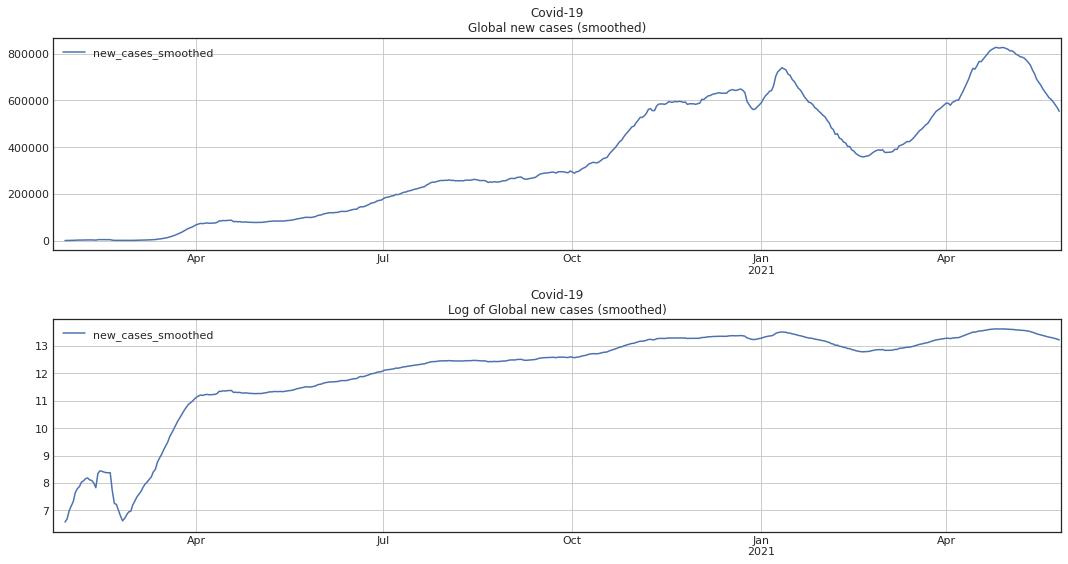

In [16]:
# Plot new cases
fig = plt.figure(figsize=(15,8))

ax1 = fig.add_subplot(211)
df_new_cases.plot(ax=ax1)
ax1.set_title("Covid-19\nGlobal new cases (smoothed)")
ax1.set_xlabel(None)
plt.grid()

ax2 = fig.add_subplot(212)
df_log_new_cases.plot(ax=ax2)
ax2.set_title("Covid-19\nLog of Global new cases (smoothed)")
ax2.set_xlabel(None)
plt.grid()

plt.tight_layout()

In [24]:
# Save data to s3
_write_dataframe_to_csv_on_s3("euronext-stocks", df_log_new_cases, "df_log_new_cases.csv")

Writing 492 records to 'df_log_new_cases.csv' in bucket 'euronext-stocks'.


### New vaccinations

In [18]:
df_new_vaccinations = df.loc[df["location"]=="World"][["date", "new_vaccinations_smoothed"]]
df_new_vaccinations.set_index("date", inplace=True)
df_new_vaccinations.index = pd.to_datetime(df_new_vaccinations.index)
df_log_new_vaccinations = np.log(df_new_vaccinations)

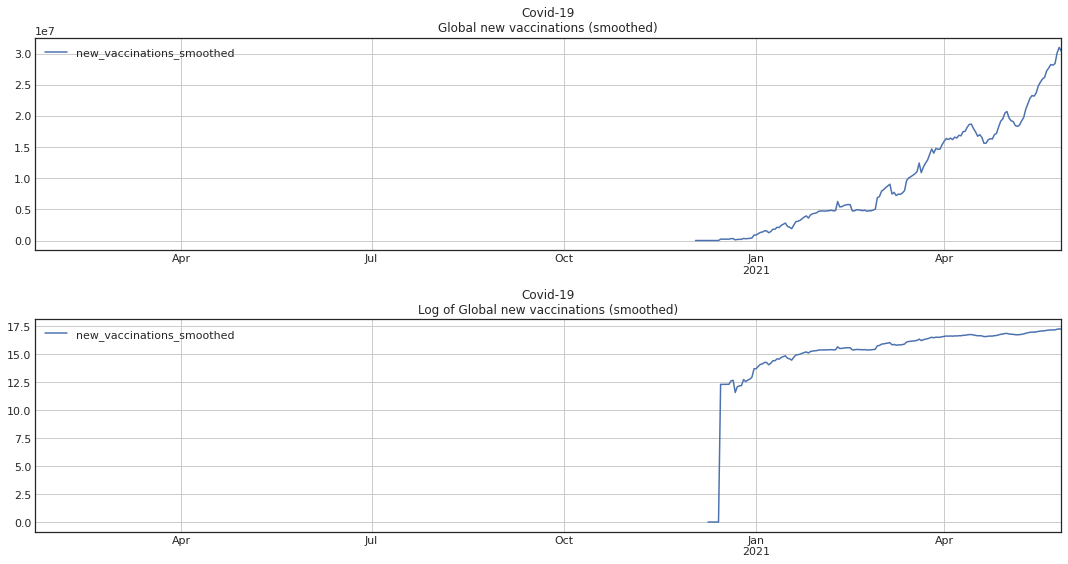

In [19]:
# Plot new vaccinations
fig = plt.figure(figsize=(15,8))

ax1 = fig.add_subplot(211)
df_new_vaccinations.plot(ax=ax1)
ax1.set_title("Covid-19\nGlobal new vaccinations (smoothed)")
ax1.set_xlabel(None)
plt.grid()

ax2 = fig.add_subplot(212)
df_log_new_vaccinations.plot(ax=ax2)
ax2.set_title("Covid-19\nLog of Global new vaccinations (smoothed)")
ax2.set_xlabel(None)
plt.grid()

plt.tight_layout()

In [25]:
# Save data to s3
_write_dataframe_to_csv_on_s3("euronext-stocks", df_log_new_vaccinations, "df_log_new_vaccinations.csv")

Writing 492 records to 'df_log_new_vaccinations.csv' in bucket 'euronext-stocks'.
